# __Artificial Neural Networks: Sentiment Analysis of Amazon Reviews__
---

[Deep Learning](https://en.wikipedia.org/wiki/Deep_learning) is revolutionising our world as we know it. Several tasks that we thought not long ago could only be performed by humans, now can be performed by machines faster, in a bigger scale and more accurately. These tasks go from recognising recognising all the objects in millions of images to driving cars without the intervention of any human. Another huge revolution has taken place in the field of computational linguistics thanks to the [Natural Language Processing (NLP)](https://en.wikipedia.org/wiki/Natural_language_processing). The ability to learn from the humongous corpus of texts produced by humans over centuries and recently digitised, has allowed the creation of [algorithms able to generate text](https://www.wired.com/story/ai-text-generator-gpt-3-learning-language-fitfully/) with an incredible resemblance to human texts, [translate texts](https://en.wikipedia.org/wiki/Google_Neural_Machine_Translation) from and to multiple languages, or [virtual assistants and chatbots](https://en.wikipedia.org/wiki/Virtual_assistant) that we can interact with by just talking to them rather than pressing buttons.

[Sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis), part of the NLP, is a contextual mining of text that is able to extract and quantify subjective information. Monitoring online conversations and using sentiment analysis might be useful for businesses that want to understand the social sentiment of their brand or a particular product. The increasing accessibility to online opinions in platforms such as Twitter, Amazon or Tripadvisor has made this tools to be more and more used in marketing departments.

In this lab we are going to use [Artificial Neural Networks (ANN)](https://en.wikipedia.org/wiki/Artificial_neural_network) to perform sentiment analysis on Amazon Reviews. Basically we will learn how to implement an algorithm that is able to tell whether a review is positive or negative. The task might seem quite simplistic, but if you think for a moment, humans need years of training before being able to speak a language and we cannot simply read and classify millions of reviews in a few minutes. Machines can.


## Exploring the dataset & pre-processing
---

The dataset we are going to use in this lab is a collection of reviews and ratings on baby products purchased on Amazon.com. This dataset is part of a Kaggle challenge, so it is publicly available in [this page](https://www.kaggle.com/shyann/amazon-baby-reviews-basics). The format of the data is in a CSV file, which is quite convenient to treat using a `pandas` data frame. Let's first load the dataset and do some exploration.

In [2]:
import pandas as pd
#products=tc.SFrame('Data/amazon_baby.csv')
df = pd.read_csv('Data/amazon_baby.csv')
# Drop any rows with NAs
df.dropna(inplace=True)
df

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5
...,...,...,...
183526,Baby Teething Necklace for Mom Pretty Donut Sh...,Such a great idea! very handy to have and look...,5
183527,Baby Teething Necklace for Mom Pretty Donut Sh...,This product rocks! It is a great blend of fu...,5
183528,Abstract 2 PK Baby / Toddler Training Cup (Pink),This item looks great and cool for my kids.......,5
183529,"Baby Food Freezer Tray - Bacteria Resistant, B...",I am extremely happy with this product. I have...,5


As you can see, we have only three different columns. One for the product name, one for the review and finally one for the rating provided. In total there are more than 180,000 reviews with ratings associated. Big numbers are perfect for training artificial neural networks, but this also will depend on how many products we have. Let's check this number by counting how many unique values we have in the column `name`.

In [3]:
# Get the unique values of the column name and compute its length
prodnum = len(df["name"].unique())
print("Number of products: ", prodnum)
ratio = len(df) / prodnum
print("Average reviews per product: ", round(ratio,2))

Number of products:  32315
Average reviews per product:  5.64


We also many different products, so the number of reviews per product is not very high. Also, the average sometimes is not very informative if the distribution of reviews is highly heterogeneous, i.e. many products with few reviews and few products with many reviews.  Let's see the distribution then.

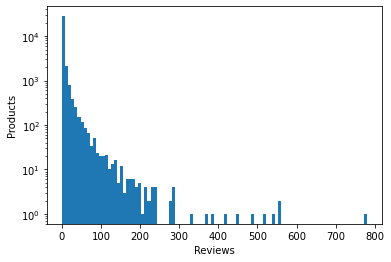

In [4]:
import matplotlib.pyplot as plt

figure=plt.figure(1)
plt.hist(df["name"].value_counts(),bins=100, log=True)
plt.xlabel('Reviews')
plt.ylabel('Products')
plt.show()

As you can see in the distribution plot, we have the majority of the products in the first bin, with around 8 or less reviews, and then we have one product with almost 800 reviews. Notice that the distribution is shown with the logarithmic scale in the y axis. This is picturing a very uneven distribution of reviews across products.

This kind of plots are also very useful for making decisions about filtering the data. For example, if we wanted to perform the analysis only for products with more than 10 reviews, we should be aware that we would be leaving out more than a half of our dataset. This could be useful for making better predictions for popular products where there is disagreement of opinions. But since what we are doing here is sentiment analysis and how reviews translate to ratings, we are not going to filter any opinions for the moment.

Next step is to have a look at the ratings of the products. Because we only have five possible values, integers from 1 to 5, it is sensible to use the `value_counts()` function to see the absolute frequencies.

In [5]:
# Counting the frequency of each value in rating column
df["rating"].value_counts()

5    106265
4     33053
3     16705
1     15100
2     11261
Name: rating, dtype: int64

As you can see above the wide majority of reviews are giving them a rating of 5. Using the same function with `normalize=True` provides the relative frequencies instead of the absolute.

In [6]:
# Counting the frequency of each value in rating column
df["rating"].value_counts(normalize=True)

5    0.582644
4    0.181228
3    0.091592
1    0.082792
2    0.061743
Name: rating, dtype: float64

Notice that the 58.33% of the reviews are giving a product 5 starts. Thus, we get a huge unbalance, not only on the reviews per product, but also on the ratings per review. Such kind of effects are quite normal when we analyse real data and we should be aware of it before making any assumptions. This also is quite useful information for setting a baseline model. For example, we know that if we predicted a rating of 5 without considering anything in the review text, we would be correct 58.33% of the time, which is quite a lot. Any machine learning model that is really working should beat that percentage if we want to predict ratings.

Discerning from a review what could be a rating of 2 and a rating of 3 can be a difficult task, especially considering this unbalance in the frequency. So, rather than predicting the actual rating we are going to focus on a more simple problem; guessing "positive" or "negative" sentiment. This will convert our problem from guessing an integer to guessing a binary status. The way we are defining this sentiment it is based on the rating. For ratings with 4 or 5, we are associating a positive sentiment (=1) and for ratings from 1 to 3 we are associating a negative sentiment (=0).

In [7]:
# Associating the sentiment based on the rating and storing in a new column
df["sentiment"] = [int(x >= 4) for x in df["rating"].to_list()]
# Calculating the percentages of each sentiment 
pos = len(df[df["sentiment"]==1])
neg = len(df[df["sentiment"]==0])
tot = len(df)
print("Positive sentiment: ",str(pos),"reviews (",str(round(pos/tot*100,2)),"% )")
print("Negative sentiment: ",str(neg),"reviews (",str(round(neg/tot*100,2)),"% )")

Positive sentiment:  139318 reviews ( 76.39 % )
Negative sentiment:  43066 reviews ( 23.61 % )


We have now created the `df["sentiment"]` column in the data frame. AS you see above, around three quarters of the ratings are labelled as positive whereas only one quarter corresponds to a negative sentiment. As before, if we had a model that always predicted a positive sentiment we would be right 76.39% of the time. So, any algorithm based on the text reviews has to beat that percentage in order to consider that it works.

Let's now have a look at the text pieces to see how we can process them. As an example, we can take a specific product and print its review texts.

In [8]:
# Select a specific product
product = 'Nature\'s Lullabies First Year Sticker Calendar'
# Create a new data frame with only that product
dfcalendar = df[df["name"]==product].copy()
# Print the first three reviews
print("Review #1: " + dfcalendar.iloc[0]["review"])
print("Rating #1: " + str(dfcalendar.iloc[0]["rating"]))
print("----------")
print("Review #2: " + dfcalendar.iloc[1]["review"])
print("Rating #2: " + str(dfcalendar.iloc[1]["rating"]))
print("----------")
print("Review #3: " + dfcalendar.iloc[2]["review"])
print("Rating #3: " + str(dfcalendar.iloc[2]["rating"]))

Review #1: Space for monthly photos, info and a lot of useful stickers come with it. It is exactly what I wanted!!
Rating #1: 5
----------
Review #2: I bought this calender for myself for my second son. It is very colorful and has room on each page to write height, weight, and what baby likes to do. There is also room on each page for a photo to be placed. The calender date boxes have room for a sticker and some fine writing. My only complaint is that it does not have as many stickers as I would like, but I just put asterisks before whatever special event happened that day. I bought one for a friend as she found it very useful as well.
Rating #2: 4
----------
Review #3: I love this little calender, you can keep track of all of baby's firsts. I like the illustrations, and the stickers too.
Rating #3: 5


As you can observe the texts we obtain are all different in terms of lengths, resulting rating and also the writing style, words used, etc. However, we can expect some common words across reviews. Words such as "like", "love" and "I" generally appear quite often in the reviews and also in these specific three. The word "stickers" is another word that appears in all three pieces of text, since the product selected is actually a Sticker Calendar. One can expect that the appearance of some kind of words are related to positive sentiment whereas other kind of words are related to negative sentiment. A common technique in NPL it is just based on that; defining a dictionary of words and count how many times and in which order they appear. The `keras` library for Python has a preprocessing text suit of tools that are specifically design for such tasks. 

One of the most popular open-source software for deep learning is [TensorFlow](https://www.tensorflow.org/), developed and widely used by Google. It is quite complicated to learn programming in TensorFlow from scratch, so the `keras` simplifies our lives substantially by providing standard models and machine learning tools that we can use as functions. I basically acts as the intermediate layer between Python and TensorFlow.

The tool we want to use here is called `Tokenizer`. For a given piece of text, the `tokenizer` will first preprocess that text by deleting any special character indicated in `filters`, then converting all capital letters to lower case if `lower=True`, and finally split the text in a list of words by the character we indicate in `split` (which is usually a space). Then it will provide the "sequences", or lists of numbers matching the words defined in `work_index` in the order they ocur in the different pieces of text.

In [9]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

texts = dfcalendar["review"].to_list()

# Define our tokenizer
token = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')
# Define our dictionary
token.word_index = {"i":1, "stickers":2, "love":3, "like":4}
# Get the sequences
sequences = token.texts_to_sequences(texts)
sequences

[[2, 1], [1, 2, 1, 4, 1, 1], [1, 3, 1, 4, 2]]

This list of three lists is the output for the three reviews selected above. The first element is a list with two numbers `[2,1]`. This indicates that the words "stickers" and "i" - remember everything is converted to lower case first - appear in this particular order in the first review. Check it out. The second list is much longer and contains many more occurrences of our 4-word dictionary. Notice that the numbers can be repeated indicating multiple occurrences of the same word. These handy sequences contain a lot of compressed information and are much more efficient when it comes to count occurrences and groups of words appearing together. 

## Building a simple classifier
----

Now we have all the tools ready to build our first sentiment classifier. In this very simple version we will use a selection of 6 different words that we can easily link to positive or negative sentiment: "love", "like", "awful", "hate", "broken" and "delay". In this case we will only check whether the word appears in the review rather than counting how many times it appears. The way to check in Python whether a value `val` is within a list `x` is as easy as `val in x`. This returns a `True` or `False` boolean, but it can be converted to `1` or `0` integers by using the formatting function `int()`.

See below how we can add this information into our new dataframe.

In [10]:
# Copy a new dataframe
dfnew = df.copy()

# Define our dictionary
token.word_index = {"love":1, "like":2, "awful":3, "hate":4, "broken":5, "delay":6}
# Apply our token to the texts
sequences = token.texts_to_sequences(dfnew["review"].astype(str))
# Store the sequences of each review in a new column
dfnew['sequences'] = sequences
# Iterate over elements of dictionary token.word_index
for key,val in token.word_index.items():
    # for example, key is "love" and val is 1
    # Create a new column based on that, if val is in the sequence add 1, 0 otherwise
    dfnew[key] = [int(val in x) for x in dfnew["sequences"].to_list()]
dfnew

,name,review,rating,sentiment,sequences,love,like,awful,hate,broken,delay
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,0,[],0,0,0,0,0,0
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,1,[1],1,0,0,0,0,0
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,1,[],0,0,0,0,0,0
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,1,"[2, 1, 1]",1,1,0,0,0,0
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,[],0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
183526,Baby Teething Necklace for Mom Pretty Donut Sh...,Such a great idea! very handy to have and look...,5,1,[],0,0,0,0,0,0
183527,Baby Teething Necklace for Mom Pretty Donut Sh...,This product rocks! It is a great blend of fu...,5,1,[2],0,1,0,0,0,0
183528,Abstract 2 PK Baby / Toddler Training Cup (Pink),This item looks great and cool for my kids.......,5,1,[],0,0,0,0,0,0
183529,"Baby Food Freezer Tray - Bacteria Resistant, B...",I am extremely happy with this product. I have...,5,1,"[2, 2]",0,1,0,0,0,0


The last 6 columns contain the values of interest and we can easily count its frequency over all reviews. `token.word_index.keys()` provides the list of words in the tokenizer's dictionary. 

In [11]:
for key in token.word_index.keys():
    # C
    num = dfnew[key].sum()
    # Calculate the percentage
    pctg = round(num/len(dfnew[key])*100,2)
    print(key,'appears in', num, 'reviews (', pctg, '%)')

love appears in 35476 reviews ( 19.45 %)
like appears in 38911 reviews ( 21.33 %)
awful appears in 697 reviews ( 0.38 %)
hate appears in 1197 reviews ( 0.66 %)
broken appears in 1441 reviews ( 0.79 %)
delay appears in 105 reviews ( 0.06 %)


Again, we see the same kind of unbalance toward the positive sentiment. In fact, this something expected and encouraging, because it means that the collection of words used might be a good representation of the reviews. However, there are some nuances to consider. Remember that the tokenizer first splits the reviews into separated words. If there is a review saying "I really don't like it.", the word "like" appears in it even though the review is clearly negative. This word, as many others, can actually represent both opinions. Then, how do we know it is useful for predicting? We don't, the machine learning algorithm will figure it out.

The next step is to perform the [train-test spit](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets), that is splitting our dataset in two different parts, one for training and one for testing. If we really want to know whether an algorithm really works, we need to test the algorithm on a dataset that "has never seen before". The prediction accuracy over this dataset is going to be considered the final accuracy of the model. It is also obvious that test dataset has to have the exact same format than the training data, so the best way to generate this test data is by splitting the original dataset in two parts. Common percentages for this split are 80% for training and 20% for testing. Also, the two parts have to be randomly sampled in order to eliminate any possible non-desired effects. The function `train_test_split()` from the machine learning library `sklearn`, is specifically designed to do this task. 

In [12]:
from sklearn.model_selection import train_test_split

X = dfnew[list(token.word_index.keys())].values
y = dfnew['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)
print("X_train:")
print(X_train)
print("y_train:")
print(y_train)


X_train:
[[0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 0 0 0]]
y_train:
[1 1 1 ... 0 0 1]


The object `X_train` is going to be the input values of our training dataset. As you see above, the inputs are a vector of six elements, with values 0 or 1 depending on whether each specific word appears on each review. The whole object is a $N_{reviews} \times N_{words}$ matrix, where $N_{reviews}$ is the number of reviews in the training dataset and $N_{words}$ is the number of words used (6 in our case). The `y_train` is the vector for our target variables, that is our sentiment, 0 for negative 1 for positive. The number of elements is $N_{reviews}$, the number of reviews on the training dataset, matching the first dimension of the training matrix. The test objects are almost exactly the same, with the difference of $N_{reviews}$ indicates now the number of elements in the testing dataset.

In the next section we will learn how to use an Artificial Neural Network to build a classifier using this training and testing sets. However, the nature of this problem we allows us to perform an even more simple classifier based on a [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) that we can use as a benchmark. The `sklearn` library has the function `LogisticRegression(`) that does not need any further operations. `.fit()` will use the training data and `.score()` returns the accuracy over the test datasets.

In [13]:
from sklearn.linear_model import LogisticRegression

# Define the Logistic Regression model
log_classifier = LogisticRegression()
# Train the model on the training dataset
log_classifier.fit(X_train, y_train)
# Get the accuracy over the test data 
score = log_classifier.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.7689777119828933


The accuracy of this model, using the 6 words selected is slightly above the 0.7639 we would get if predicted that all reviews were positive. Although technically is a little better, it is not much of an improvement. Will an Artificial Neural Network do better using the same words? 

## Classifier based on Artificial Neural Networks
---

Let's see if we can improve our previous model by using Artificial Neural Networks (ANN). As mentioned above `keras` library is one of the best for developing ANNs in Python. Although the concept of ANN might be complicated and understanding them thoroughly can take a lot of time, implementing them once we have the training and testing datasets it is quite simple. The process always follows 3 main steps:
1. __Definition__: Here is where we explicitly create the network structure, its layers type and determine the activation functions for each neuron.   
2. __Training (fit)__: Once the ANN model is defined, the training phase uses the training dataset to set the best values for all the parameters of the network. Here we can also define some aspects about how the network learns from the data.  
3. __Evaluation__: After all parameters of the network are determined, the ANN model is ready for making predictions. In this phase typically we will use the test datasets to get the accuracy of our model.

Our first ANN will be very simple, consisting of a [Sequential model](https://keras.io/guides/sequential_model/) with of only one hidden layer of 6 neurons. The corresponding chart of the structure would be the following:

![title](ANN_structure.png)

The input layer consists of six neurons, one for each word, whose values can only be 1 or 0. Thus, the input layer of a review saying *"I like the product, but the packaging it is awful - it arrived with broken pieces."* would be $X_1=0$, $X_2=1$, $X_3=1$, $X_4=0$, $X_5=1$ and $X_6=0$, because it contains the words "like", "awful" and "broken". These values are passed to each of the six neurons on the hidden layer that would make an operation using seven parameters, one per each link into the neuron plus one for the bias term. After this operation the neuron applies the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function and passes the result to the output layer. The output layers collects the results of each neuron in the hidden layers and also performs an operation using one parameter per each link plus another for the bias. In this case however, instead of using the ReLU activation function the network uses the [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) one. The reason is related to the output. We looking for predicting only one target variable; the sentiment. That is why we only have one neuron in the output layer. This variable is also binary, taking values of 0 or 1, so we want function that converts any possible input into these only two possible values. Sigmoid activation functions are the go-to for binary choices like this one.

This is the main rationale for the structure of the ANN, which is the most difficult part. Each type of layer is added into the structure using the `model.add()`. In our current case we only use Dense layers, i.e. all neurons connected to all neurons of the previous layer. [Here](https://machinelearningknowledge.ai/different-types-of-keras-layers-explained-for-beginners/) you can find more types of layers you can use and basic explanations. The `model.compile()` function is for selecting the loss functions and metrics, among other things. Again, our problem is about guessing a binary choice, so setting `loss=binary_crossentropy` and using accuracy for the metrics is a wise decision here. If the ANN was built for solving a regression problem, then other decisions such as `loss=mean_abolute_error` and `metrics=["mse"]` would be better. In [this page](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/) you have some cases explained.

In [14]:
### 1. Definition ###
from keras.models import Sequential
from keras import layers

# Input dimenstion (Number of features)
input_dim = X_train.shape[1]

model = Sequential()
# The input layer is not explicitly added and defined in the input_dim
model.add(layers.Dense(6, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
# 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 42        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


`model.summary()` lets us know the structure of the ANN and how many parameters the network needs to fit with the training dataset. Remember, as any fitting problem the ration between the data and the number of parameters is something we should keep an eye on. The more data points per parameter, the better. You can see how if we keep adding layers or neurons, the number of parameters to fit quickly escalates. And this is the main reason why Deep Learning always needs large amounts of data.

Let's now train our Artificial Neural Network. This is the step that usually takes longer, especially if you are using a laptop or an old computer. Although we are not training a very large ANN, there is a lot of calculations to make. As a reference, my laptop took 10-15 seconds. If you see that it takes much longer you might want to consider running this notebook within [Google's Colab](https://colab.research.google.com). 

In [15]:
### 2. Training (fit) ###
history = model.fit(X_train, y_train, epochs=12, verbose=True, validation_split=0.2, batch_size=500)

Epoch 1/12
234/234 [==============================] - 1s 3ms/step - loss: 0.6424 - accuracy: 0.7565 - val_loss: 0.5652 - val_accuracy: 0.7616
Epoch 2/12
234/234 [==============================] - 1s 2ms/step - loss: 0.5515 - accuracy: 0.7663 - val_loss: 0.5346 - val_accuracy: 0.7616
Epoch 3/12
234/234 [==============================] - 1s 3ms/step - loss: 0.5308 - accuracy: 0.7634 - val_loss: 0.5286 - val_accuracy: 0.7616
Epoch 4/12
234/234 [==============================] - 1s 3ms/step - loss: 0.5293 - accuracy: 0.7606 - val_loss: 0.5273 - val_accuracy: 0.7616
Epoch 5/12
234/234 [==============================] - 0s 2ms/step - loss: 0.5268 - accuracy: 0.7628 - val_loss: 0.5269 - val_accuracy: 0.7616
Epoch 6/12
234/234 [==============================] - 1s 2ms/step - loss: 0.5228 - accuracy: 0.7661 - val_loss: 0.5267 - val_accuracy: 0.7616
Epoch 7/12
234/234 [==============================] - 0s 2ms/step - loss: 0.5234 - accuracy: 0.7652 - val_loss: 0.5265 - val_accuracy: 0.7616
Epoch 

The network is already trained and all relevant information about how the process evolved is in the `history` object. Particularly, it is very useful to plot the training and validation curves in order to spot any problems such as [overfitting](https://en.wikipedia.org/wiki/Overfitting). The [validation dataset](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets) is like a test dataset used only during the training process and created from the training dataset that we have input. In our case,  we have defined in `validation_split=0.2` that our validation dataset is 20% of the training dataset. It is important to stress that at this point we haven't still used the test dataset at any moment.

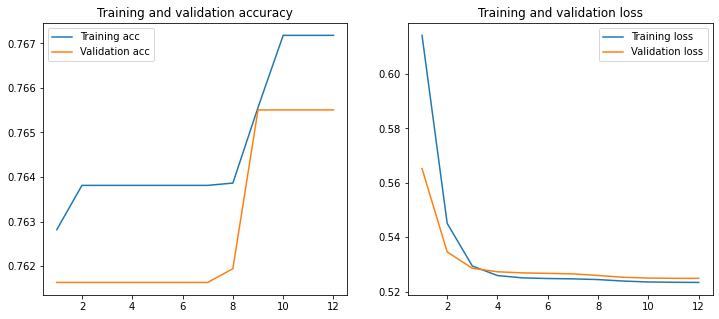

In [16]:
# Function for plotting the training & validation curves
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, label='Training acc')
    plt.plot(x, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, label='Training loss')
    plt.plot(x, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

The curves for both accuracy and loss look very convergent and the difference between them is relatively quite small. At the end of the training process the training and validation have very similar values. These reasons lead us to think that there are no signs of overfitting, so we can proceed with the evaluation. Now we are going to make use of the test dataset and compare the accuracy with the training dataset. We can expect some divergence, since the test data has never been seen by our model, but any big difference should sound some alarms.

In [17]:
### 3. Evaluation ###
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7668
Testing Accuracy:  0.7690


The conclusion is a little bittersweet. Good news are the accuracy between both datasets is very similar, the ANN is working fine. Bad news are that the model is not really improving the performance with respect to the Logistic Regression model (76.89%) or the null case were all predictions are positive sentiment (76.39%). Remember that so far we are only using six words in our dictionary for processing the reviews. The vocabulary to express opinions is much more rich in terms of words used. Why don't we try using more words?

<div class="alert alert-block alert-info"><b>Exercise 1:</b><br>Another interesting pre-processing that could increase the performance of the classifier is using two different sets of words. Thus, we could define a dictionary with "positive" words, pass the tokenizer and count how many of those there are in the review. The same could be done for "negative" words.<br><br>Try this approach and compare the performance. Be creative and choose your own words for the two groups.<br><br><i>Hint: You'll need to change the input layer because now we only pass 2 variables.</i></div>

## Using all tokens
-----

As we have seen, using only six different words in our dictionary might be limiting the potential of artificial neural networks. They tend to perform better as we increase the number of inputs, so they can detect and use more intricate patterns. However, manually selecting those necessary words can be a bit of a hussle. Fortuntalely, the tokenizer from keras is well equipped for that. It has a function `tokenizer.fit_on_texts()` that allows creating a dictionary of words based on the actual text we want to process. This function orders the word dictionary according to their frequency, words that appears more will be allocated first in the dictionary. When initialising the tokenizer, we can also set a threshold, so that we keep the top `num_words` words in terms of their frequency, the rest will not be indexed and will not appear in the sequences.

In [35]:
# Define the tokenizer.
tokenizer = Tokenizer(num_words = 1000, lower=True)
# Convert the column reviews to a list of texts properly formatted
alltext = df["review"].astype(str).to_list()
# Extract the dictionary of words from the text
tokenizer.fit_on_texts(alltext)
# Create a dataframe with the word count
dfwords = pd.DataFrame.from_dict(tokenizer.word_counts, orient="index",columns=["frequency"])
# Show the top 15 words
dfwords.sort_values(by="frequency", ascending=False).head(15)

,frequency
the,764917
and,456073
it,431161
i,431144
to,417882
a,346389
is,256581
this,223329
for,216498
my,184290


If we create a data frame from the `tokenizer.word_counts` we can easily inspect the occurrences of our words. As you see above the top words correspond more or less to the most used in English language. However, if we show the words further down, we can see how those are still very frequent and more related to opinions and reviews. 

In [44]:
# Show the words between the 600th and 620th position.
dfwords.sort_values(by="frequency", ascending=False).iloc[600:620,:]

,frequency
nicely,3010
option,3004
beautiful,3004
camera,2988
extremely,2986
leave,2968
medela,2967
uses,2944
held,2943
waste,2923


Another change we are introducing here is the way we process the sequences after the tokenizer being fit in the text. Rather than counting the occurrence of words in the text, we are going to use directly the sequence vector. This allows to consider further complexities in the natural language. For example, before the subsets "really like" and "don't like" were difficult to classify. Both have the word like in it but one is clearly positive whereas the other is clearly negative. The tokenizer we have fit has de following words encoded in its dictionary: `{"like":38, "really":64, "dont": 891}` - remember the tokenizer removes the special characters. Thus, the first subset will be converted as the pair `[64,38]` whereas the second as `[891,38]`. The ANN will now be able to distinguish that when the first pair appears in the sequence it will associate a positive sentiment, whereas if it finds the second pair it will associate a negative sentiment. This can increase substantially the performance of our classifier.

There is one problem to consider though. The lengths of the sequences will vary from one review to the other, but the vector we have to input into the ANN has to be of a fixed size for all reviews. In order to homogenize all these vectors of different lengths, `pad_sequences()` allows keep only the first `maxlen` values and truncate the rest, or if the sequence is shorter, keep all values and fill the rest with zeros. This way all reviews will have the same sequence length.

In [51]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Transform training reviews into sequences:  
sequences = tokenizer.texts_to_sequences(df["review"].astype(str).to_list())
padded = pad_sequences(sequences, maxlen=50, padding='post', truncating='post')
df["sequences"] = list(padded)
df

,name,review,rating,sentiment,sequences
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,0,"[42, 457, 23, 615, 17, 12, 10, 21, 220, 690, 4..."
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,1,"[3, 262, 2, 16, 21, 447, 4, 52, 367, 2, 78, 10..."
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,1,"[28, 157, 2, 207, 2, 828, 73, 3, 216, 114, 1, ..."
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,1,"[8, 7, 6, 66, 59, 220, 1, 236, 4, 18, 21, 227,..."
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,"[41, 11, 10, 211, 18, 953, 897, 29, 4, 214, 5,..."
...,...,...,...,...,...
183526,Baby Teething Necklace for Mom Pretty Donut Sh...,Such a great idea! very handy to have and look...,5,1,"[423, 6, 31, 463, 28, 709, 5, 18, 2, 242, 64, ..."
183527,Baby Teething Necklace for Mom Pretty Donut Sh...,This product rocks! It is a great blend of fu...,5,1,"[8, 66, 3, 7, 6, 31, 11, 2, 58, 1, 11, 240, 20..."
183528,Abstract 2 PK Baby / Toddler Training Cup (Pink),This item looks great and cool for my kids.......,5,1,"[8, 241, 216, 31, 2, 811, 9, 10, 211, 4, 203, ..."
183529,"Baby Food Freezer Tray - Bacteria Resistant, B...",I am extremely happy with this product. I have...,5,1,"[4, 102, 605, 195, 15, 8, 66, 4, 18, 109, 9, 6..."


We now create the train and test split, as before:

In [56]:
import numpy as np

# Convert to list and then to numpy array (otherwise does not work)
X = np.array(df["sequences"].to_list())
y = np.array(df['sentiment'].to_list())

# Use the train_test_split from the sklearn library
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)

Because we now have integers representing words with different meanings, we also need to add a couple of extra layers in our ANN accounting for this kind of input. Typically in NPL we use an input [Embedding layer](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/) that helps to deal with this integer based representation. The first argument in the `layers.Embedding()` is the vocabulary, which in our case we have already define it in the tokenizer. The second argument is the dimension of the layer output, the higher the dimension the more parameters to fit. Finally, `input_length` indicates the length of the vector input, which we have already defined in the `pad_sequence()` function. The Embedding layer output is 2D, so if we want to connect it with the previous ANN structure, we first need to convert it to 1D vector using the `layers.Flatten()`. The rest of the structure remains exactly the same.  

In [87]:
from keras.layers.embeddings import Embedding

# Clear the session of previous parameters
keras.backend.clear_session()

# 1. Definition
model = Sequential()
model.add(layers.Embedding(1000, 32, input_length=50))
model.add(layers.Flatten())
model.add(layers.Dense(6, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 32)            32000     
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 9606      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 41,613
Trainable params: 41,613
Non-trainable params: 0
_________________________________________________________________


As you see the number of parameters to fit has increased substantially due to the embedding layer. Again, if the training takes very long, consider running this within [Google's Colab](https://colab.research.google.com). 

Epoch 1/12
117/117 [==============================] - 3s 18ms/step - loss: 0.5931 - accuracy: 0.7301 - val_loss: 0.4174 - val_accuracy: 0.7984
Epoch 2/12
117/117 [==============================] - 2s 17ms/step - loss: 0.3762 - accuracy: 0.8287 - val_loss: 0.3412 - val_accuracy: 0.8512
Epoch 3/12
117/117 [==============================] - 2s 16ms/step - loss: 0.3253 - accuracy: 0.8579 - val_loss: 0.3336 - val_accuracy: 0.8532
Epoch 4/12
117/117 [==============================] - 2s 16ms/step - loss: 0.3162 - accuracy: 0.8620 - val_loss: 0.3316 - val_accuracy: 0.8540
Epoch 5/12
117/117 [==============================] - 2s 15ms/step - loss: 0.3069 - accuracy: 0.8671 - val_loss: 0.3316 - val_accuracy: 0.8547
Epoch 6/12
117/117 [==============================] - 2s 16ms/step - loss: 0.3014 - accuracy: 0.8703 - val_loss: 0.3316 - val_accuracy: 0.8535
Epoch 7/12
117/117 [==============================] - 3s 22ms/step - loss: 0.2939 - accuracy: 0.8753 - val_loss: 0.3350 - val_accuracy: 0.8540

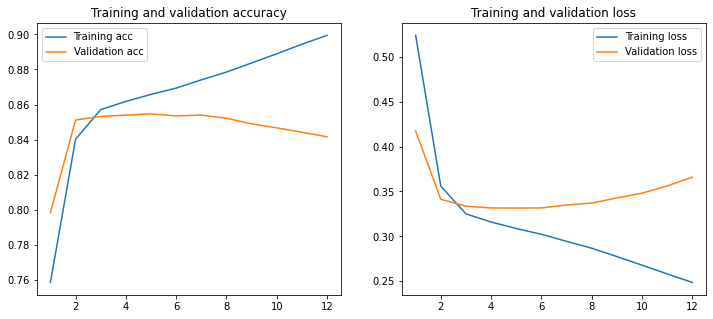

In [88]:
# 2. Training
history = model.fit(X_train, y_train, epochs=12, verbose=True, validation_split=0.2, batch_size=1000)
plot_history(history)
# 3. Evaluation
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

The results now show a very different picture. On one hand we have a testing accuracy that has increased to 84.48%, substantially higher than the previous 76.90% and also than the 76.39% of the null model (all predictions positive). This is great news and a clear sign that using more words and a slightly more complex structure make the Artificial Neural Networks a good model for sentiment analysis.

On the other hand, we can appreciate from the plots that our model suffers from overfitting. Thus, the training dataset curve keeps increasing as the epochs go on but the validation dataset saturates after few epochs, it even decreases towards the end. The same conclusion can be drawn looking at the loss functions. This means that the our model is more and more specialising to improve predictions in the training dataset, but at expense of the accuracy in the test data. In fact, we can see how there is 5% difference in the evaluation of train and test datasets. The results are still quite good but it is clear that there is still room for [reducing the overfitting](https://www.youtube.com/watch?v=DEMmkFC6IGM) and improving our model.

<div class="alert alert-block alert-info"><b>Exercise 2:</b><br>Try changing some parts of the model to see whether you can further improve its prediction accuracy. Some modifications can include:<ul>
  <li>Change the maximum number of words (pad length)</li>
  <li>Add more hidden layers in the network</li>
  <li>Change the number of neurons in the layer</li>
  <li>Change the activation function</li>
  <li>Replacing the Flatten() layer by <a href="https://keras.io/api/layers/pooling_layers/global_average_pooling1d/">GlobalAveragePooling1D()</a></li>
</ul></div>

<div class="alert alert-block alert-info"><b>Exercise 3:</b><br>Write your own collection of made up reviews and use the Artificial Neural Network for predicting their sentiment. </div>

---
<div style="text-align: right ;font-size: small; color: gray"> Notebook by <a href="http://mariogutierrezroig.net">Mario Gutiérrez-Roig</a>, Lecturer in Data Science and Statistics at the University of Essex <a href="http://creativecommons.org/licenses/by-sa/4.0/" rel="license"><img src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" alt="Licencia de Creative Commons" hspace="10" align="right"></a></div>